In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

from superRes.fid_loss import *
from superRes.generators import *
from superRes.inception import InceptionV3
import geffnet
import time

In [2]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'
path_lowRes = path/'DIV2K_train_LR_mild'

In [3]:
def det_DIV2k_data(bs:int, sz:int):
    lowResSuffix = 'x4m'
    src = ImageImageList.from_folder(path_lowRes).split_by_idxs(train_idx=list(range(0,800)), valid_idx=list(range(800,900)))

    data = (src.label_from_func(lambda x: path_fullRes/(x.name).replace(lowResSuffix, '')).transform(
            get_transforms(
                max_zoom=2.
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [4]:
data = det_DIV2k_data(bs=10, sz=256)
# data.show_batch()
x, y = data.one_batch()

In [5]:
x.shape

torch.Size([10, 3, 256, 256])

In [6]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx]).cuda()
model.eval()

InceptionV3(
  (blocks): ModuleList(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

In [7]:
f = fid(x, y)

In [8]:
bs=20
sz=128
lr = 1e-2
wd = 1e-3
keep_pct=1.0
epochs = 10
nf_factor = 2

model = geffnet.mobilenetv3_100

learn_gen = gen_learner_wide(data=data,
                             gen_loss=fid,
                             arch = model,
                             nf_factor=nf_factor)

In [9]:
learn_gen.fit_one_cycle(1, lr*10)

epoch,train_loss,valid_loss,time
0,429.884857,429.500228,12:07


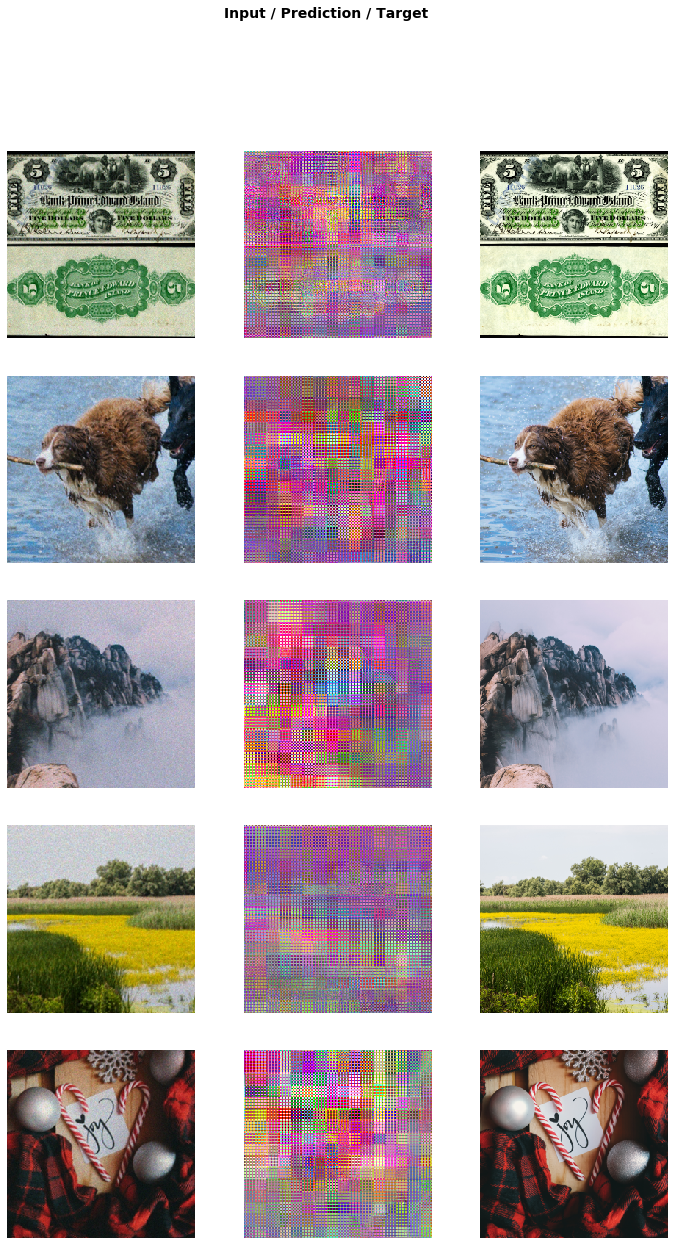

In [10]:
learn_gen.show_results()